# Procjena dubine objekata iz jedne slike

Procjena dubine važna je grana računalnog vida. Cilj procjene dubine je odrediti koliko su objekti na slici daleko od pozicije snimanja. 

Procjena dubine dijeli se na dvije vrste: monokularna procjena dubine i stereoskopska procjena dubine. U monokularnoj procjeni dubine, dubina objekata se procjenjuje iz jedne slike dok se u stereoskopskoj procjeni dubine dubina objekata procjenjuje pomoću dvije slike dobivene iz odmaknutih senzora

In [ ]:
import torch
import cv2
import os.path
from google.colab import drive
import glob
from torchvision.io import read_image
import scipy.io
import matplotlib.pyplot as plt
import h5py
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import math
import sys
from IPython.display import display, Math, Latex, Markdown
import random

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Definicija modela

Model za procjenu dubine se sastoji od dvije komponente. 

Prva komponenta procjenjuje dubinu na globalnoj razini, dok druga komponenta procjenjuje na lokalnoj razini. 

Komponenta koja procjenjuje dubinu na globalnoj razini sastoji se od 5 konvolucijskih slojeva. Izlaz tih konvolucijskih slojeva šalje se u neuronsku mrežu sa 4096 skrivenih slojeva koja zbog potpune povezanosti u skrivenom sloju može procjenjivati dubinu na globalnoj razini. Izlaz neuronske mreže je mapa procjenjenih dubina slike na globalnoj razini.

Komponenta koja procjenjuje dubinu na lokalnoj razini sastoji se od 3 konvolucijska sloja. 

Izlaz prvog konvolucijskog sloja se spaja sa izlazom iz mreže za globalnu procjenu te spojeni podaci koriste kao ulaz u druga 2 konvolucijska sloja. Na taj način mreži je omogućeno da ima uvid u globalnu procjenu dubine prilikom lokalne procjene.

Gubitak modela izražen je kao kvadratna pogreška koja je invarijanzna na skaliranje i dana je izrazom:

$ D(y, y^*) = \frac{1}{n} \sum_{i = 1}^{n}{(log(y_i) - log(y_i^*) + \alpha(y, y^*))^2}$ 

gdje je n broj piksela u slici, y_i je vrijednost piksela u mapi procjenjih dubina, dok je y_i^* vrijednost stvarne dubine u pikselu na istoj poziciji.
Funkcija $\alpha(y, y^*)$ definirana je na sljedeći način:

$\alpha(y, y^*) = \frac{1}{n} \sum_{i}{(log(y_i^*) - log(y_i))}$

In [ ]:
class NetworkModule(torch.nn.Module):
  def __init__(self):
    super(NetworkModule, self).__init__()

    self.coarse1 = torch.nn.Conv2d(in_channels=3, out_channels=96, kernel_size=(11, 11), stride=4)
    self.coarse1pool = torch.nn.MaxPool2d(kernel_size=(2, 2))

    self.coarse2 = torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5), padding="same")
    self.coarse2pool = torch.nn.MaxPool2d(kernel_size=(2, 2))

    self.coarse3 = torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3,3), padding="same")

    self.coarse4 = torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3), padding="same")

    self.coarse5 = torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=2)

    self.coarse6 = torch.nn.Linear(8 * 6 * 256, 4096)
    self.coarse7 = torch.nn.Linear(4096, 55 * 74)

    self.dropout = torch.nn.Dropout(0.1)

    self.fine1 = torch.nn.Conv2d(in_channels=3, out_channels=63, kernel_size=(9, 9), stride=2)
    self.fine1pool = torch.nn.MaxPool2d(kernel_size=(2, 2))

    self.fine2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5), padding=2, padding_mode="zeros")
    self.fine3 = torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(5, 5), padding=2, padding_mode="zeros")

  def forward(self, x):
    c1 = self.coarse1(x)
    c1 = self.coarse1pool(c1)
    c1 = torch.relu(c1)
    c1 = self.coarse2(c1)
    c1 = self.coarse2pool(c1)
    c1 = torch.relu(c1)
    c1 = self.coarse3(c1)
    c1 = torch.relu(c1)
    c1 = self.coarse4(c1)
    c1 = torch.relu(c1)
    c1 = self.coarse5(c1)
    c1 = torch.relu(c1)
    c1 = self.coarse6(c1.flatten(start_dim=1, end_dim=3))
    c1 = self.dropout(c1)
    c1 = torch.relu(c1)
    c1 = self.coarse7(c1)
    
    c1 = c1.reshape((-1, 1, 55, 74))

    f1 = self.fine1(x)
    f1 = self.fine1pool(f1)
    f1 = torch.cat((c1, f1), dim=1)
    f1 = torch.relu(f1)
    f1 = self.fine2(f1)
    f1 = torch.relu(f1)
    f1 = self.fine3(f1)
    return f1

  def loss(self, y_out, y_gt):
    alpha = torch.mean(torch.log(y_gt + 10e-6) - y_out)
    return torch.mean((y_out - torch.log(y_gt + 10e-6) + alpha)**2)

# Podaci

Učenje modela vršilo se na skupu podataka NYUv2Depth. Navedeni skup podataka sadrži 1449 označenih slika. Oznake dubina dane su kao matrice kojima je broj redaka jednak visini slike i broj stupaca jednak širini slike. Vrijednosti u matrici predstavljaju dubine na pojedinim pikselima.

Skup podataka je podjeljen tako da je 60% slika namjenjeno za treniranje, 20% slika je predviđeno za provjeru svojstva generalizacije između epoha i 20% slika je iskorišteno za konačno testiranje modela.

In [ ]:
class NYUv2DepthDataset(torch.utils.data.Dataset):
  def __init__(self, image_transform = None, label_transform=None, common_transform=None) -> None:
    super().__init__()

    print("Loading NYUv2 Depth dataset")
    self.image_transform = image_transform
    self.label_transform = label_transform
    self.common_transform = common_transform
    
    self.image_width = 640
    self.image_height = 480

    f = h5py.File('/content/gdrive/MyDrive/depth-estimation/nyu_depth_v2_labeled.mat', 'r')

    temp_images = f.get("images")
    new_images = []
    for i in range(len(temp_images)):
      new_images.append(np.moveaxis(temp_images[i], 0, 2))
      new_images[i] = cv2.cvtColor(new_images[i], cv2.COLOR_BGR2RGB)
      new_images[i] = cv2.resize(new_images[i], (228, 304))
      new_images[i] = cv2.rotate(new_images[i], cv2.ROTATE_90_CLOCKWISE)
      new_images[i] = new_images[i].transpose(2, 0, 1)
    self.images = np.array(new_images)

    temp_labels = f.get("depths")

    new_labels = []
    for i in range(len(temp_labels)):
        new_labels.append(temp_labels[i])
        new_labels[i] = cv2.resize(new_labels[i], (55, 74))
        new_labels[i] = cv2.rotate(new_labels[i], cv2.ROTATE_90_CLOCKWISE)
        new_labels[i] = np.expand_dims(new_labels[i], axis=0)
    self.labels = np.array(new_labels)

    assert len(self.images) == len(self.labels)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image = torch.Tensor(self.images[index])
    label_image = torch.Tensor(self.labels[index])
    if self.image_transform is not None:
      image = self.image_transform(image)
    if self.label_transform is not None:
      label_image = self.label_transform(label_image)
    if self.common_transform is not None:
      seed = np.random.randint(2147483647) # make a seed with numpy generator 
      random.seed(seed) # apply this seed to img tranfsorms
      torch.manual_seed(seed) # needed for torchvision 0.7
      image = self.common_transform(image)
      random.seed(seed) # apply this seed to img tranfsorms
      torch.manual_seed(seed) # needed for torchvision 0.7
      label_image = self.common_transform(label_image)
    return image, label_image

# Treniranje modela

Treniranje modela se provodi u 1000 epoha. Za optimizaciju se koristi algoritam Adam sa stopom učenja u iznosu od 0.0001.

Za pretprocesiranje slika koristi se normalizacija koja vrijednosti piksela u slikama preslikava u raspon [0, 1].
Dodatno se prilikom dohvaćanja slike slika horizontalno okreće s vjerojatnosti 0.5.

In [ ]:
BATCH_SIZE = 32
NUM_OF_EPOCHS = 1000
EPOCH_CHECKPOINTS = False
SAVE_MODEL = True
SAVE_MODEL_PATH = "."

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running train on {device}")

print("Loading dataset")
image_transform = []
label_transform = []
common_transform = []
#image_transform.append(transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]))
common_transform.append(transforms.RandomHorizontalFlip())
common_transform.append(transforms.RandomRotation(degrees=(-5, 5), expand=False))
image_transform = transforms.Compose(image_transform)
label_transform = transforms.Compose(label_transform)
common_transform = transforms.Compose(common_transform)

dataset = NYUv2DepthDataset(image_transform, label_transform, common_transform)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [0.60, 0.2, 0.2])

print("Loaded dataset")

print("Loading data loaders")

train_data_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

print("Loaded data loaders")

Running train on cuda
Loading dataset
Loading NYUv2 Depth dataset
Loaded dataset
Loading data loaders
Loaded data loaders


Initializing model
Initialized model
Starting training model
  0%|          | 0/1000 [00:00<?, ?it/s]

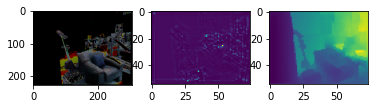

Epoch 50 / 1000 Loss: 0.294:   5%|▌         | 50/1000 [03:42<1:06:10,  4.18s/it]

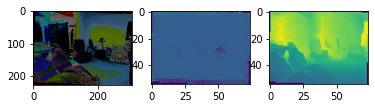

Epoch 100 / 1000 Loss: 0.256:  10%|█         | 100/1000 [07:09<1:01:21,  4.09s/it]

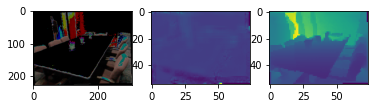

Epoch 150 / 1000 Loss: 0.238:  15%|█▌        | 150/1000 [10:33<59:13,  4.18s/it]

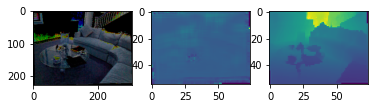

Epoch 200 / 1000 Loss: 0.223:  20%|██        | 200/1000 [13:58<54:12,  4.07s/it]

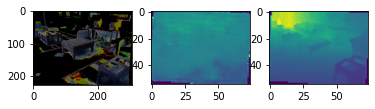

Epoch 250 / 1000 Loss: 0.215:  25%|██▌       | 250/1000 [17:21<50:00,  4.00s/it]

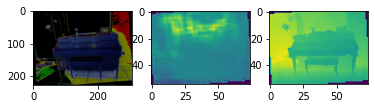

Epoch 300 / 1000 Loss: 0.205:  30%|███       | 300/1000 [20:42<46:57,  4.02s/it]

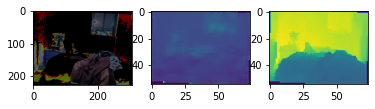

Epoch 350 / 1000 Loss: 0.198:  35%|███▌      | 350/1000 [24:06<43:48,  4.04s/it]

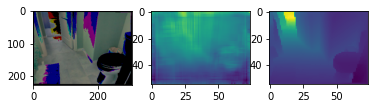

Epoch 400 / 1000 Loss: 0.184:  40%|████      | 400/1000 [27:31<40:08,  4.01s/it]

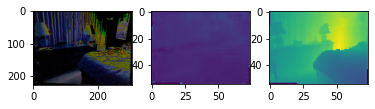

Epoch 450 / 1000 Loss: 0.178:  45%|████▌     | 450/1000 [30:54<36:46,  4.01s/it]

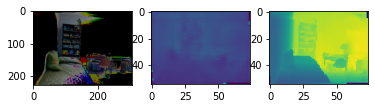

Epoch 500 / 1000 Loss: 0.179:  50%|█████     | 500/1000 [34:16<33:23,  4.01s/it]

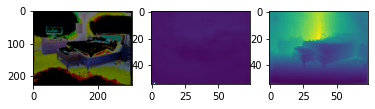

Epoch 550 / 1000 Loss: 0.215:  55%|█████▌    | 550/1000 [37:37<30:01,  4.00s/it]

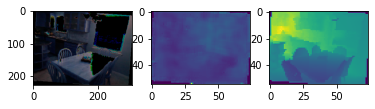

Epoch 600 / 1000 Loss: 0.199:  60%|██████    | 600/1000 [40:58<26:41,  4.00s/it]

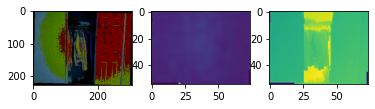

Epoch 650 / 1000 Loss: 0.187:  65%|██████▌   | 650/1000 [44:18<23:16,  3.99s/it]

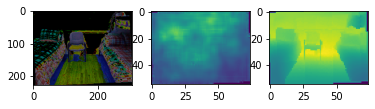

Epoch 700 / 1000 Loss: 0.175:  70%|███████   | 700/1000 [47:39<19:58,  3.99s/it]

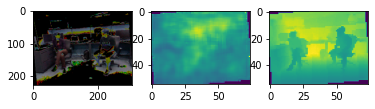

Epoch 750 / 1000 Loss: 0.182:  75%|███████▌  | 750/1000 [51:00<16:47,  4.03s/it]

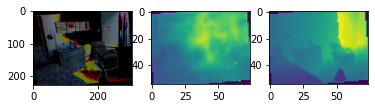

Epoch 800 / 1000 Loss: 0.179:  80%|████████  | 800/1000 [54:21<13:21,  4.01s/it]

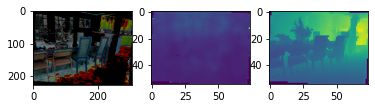

Epoch 850 / 1000 Loss: 0.183:  85%|████████▌ | 850/1000 [57:42<10:08,  4.06s/it]

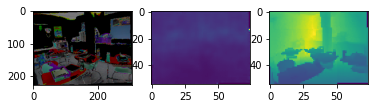

Epoch 900 / 1000 Loss: 0.178:  90%|█████████ | 900/1000 [1:01:03<06:42,  4.03s/it]

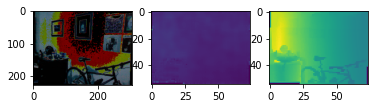

Epoch 950 / 1000 Loss: 0.173:  95%|█████████▌| 950/1000 [1:04:24<03:20,  4.01s/it]

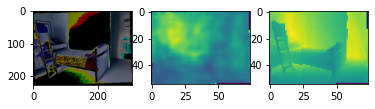

Epoch 1000 / 1000 Loss: 0.186: 100%|██████████| 1000/1000 [1:07:45<00:00,  4.07s/it]


In [ ]:
print("Initializing model")
model = NetworkModule().to(device)
print("Initialized model")

print("Starting training model")
writer = SummaryWriter()
optimizer = torch.optim.SGD([
    {"params": model.coarse1.parameters(), "lr": 1e-3},
    {"params": model.coarse2.parameters(), "lr": 1e-3},
    {"params": model.coarse3.parameters(), "lr": 1e-3},
    {"params": model.coarse4.parameters(), "lr": 1e-3},
    {"params": model.coarse5.parameters(), "lr": 1e-3},
    {"params": model.coarse6.parameters(), "lr": 0.1},
    {"params": model.coarse7.parameters(), "lr": 0.1},
    {"params": model.fine1.parameters(), "lr": 1e-3},
    {"params": model.fine2.parameters(), "lr": 1e-2},
    {"params": model.fine3.parameters(), "lr": 1e-3}
], lr=1e-3, momentum = 0.9)

best_model = None
best_loss = None

for epoch in (pbar := tqdm(range(NUM_OF_EPOCHS), total=NUM_OF_EPOCHS, file=sys.stdout)):
    model.train()
    num_batches_train = math.ceil(len(train_set) / BATCH_SIZE)

    train_losses = []
    for j, batch in enumerate(iter(train_data_loader)):
      optimizer.zero_grad()
      
      image_batch, label_batch = batch
      image_batch, label_batch = image_batch.to(device), label_batch.to(device)
      y_out = model.forward(image_batch)
      loss = model.loss(y_out, label_batch)
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      train_losses.append(float(loss.cpu().detach().numpy()))

    writer.add_scalar("Loss/train", loss, epoch)

    val_losses = []
    model.eval()
    with torch.no_grad():
      num_batches_val = math.ceil(len(val_set) / BATCH_SIZE)
      for j, batch in enumerate(iter(val_data_loader)):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        y_out = model.forward(image_batch)
        loss = model.loss(y_out, label_batch)
        val_losses.append(float(loss.cpu().detach().numpy()))

    if epoch % 50 == 0:
      f, axarr = plt.subplots(1, 3)
      display_image = np.moveaxis(image_batch.cpu().detach().numpy().astype(np.int8)[0], 0, 2)
      display_y_out = np.exp(y_out.cpu().detach().numpy()[0,0])
      display_y_gt = label_batch.cpu().detach().numpy()[0,0]
      axarr[0].imshow(display_image)
      axarr[1].imshow(display_y_out)
      axarr[2].imshow(display_y_gt)
      plt.show()

    pbar.set_description(f"Epoch {epoch + 1} / {NUM_OF_EPOCHS} " + f"Loss: {np.mean(np.array(val_losses)):.3f}")
    writer.add_scalar("Loss/test", loss, epoch)

    if best_loss == None or best_loss > np.mean(np.array(val_losses)):
      best_loss = np.mean(np.array(val_losses))
      torch.save(model.state_dict(), SAVE_MODEL_PATH + f"/best_model.pt")

    if EPOCH_CHECKPOINTS and (epoch + 1) % 100 == 0:
      torch.save(model.state_dict(), SAVE_MODEL_PATH + f"/model_{epoch + 1}.pt")

# Testiranje

In [ ]:
model = NetworkModule().to(device)
model.load_state_dict(torch.load("./best_model.pt"))

num_batches_test = len(test_data_loader)
for j, batch in (pbar := tqdm(enumerate(iter(test_data_loader)), total=num_batches_test, file=sys.stdout)):
    with torch.no_grad():
      image_batch, label_batch = batch
      image_batch, label_batch = image_batch.to(device), label_batch.to(device)
      
      y_out = model.forward(image_batch)
      loss = model.loss(y_out, label_batch)
      pbar.set_description(f"Loss: {loss.cpu().detach().numpy():.2f}")

      for k in range(y_out.shape[0]):
        f, axarr = plt.subplots(1, 3)
        display_image = np.moveaxis(image_batch.cpu().detach().numpy().astype(np.int8)[k], 0, 2)
        display_y_out = np.exp(y_out.cpu().detach().numpy()[k,0])
        display_y_gt = label_batch.cpu().detach().numpy()[k,0]
        axarr[0].imshow(display_image)
        axarr[1].imshow(display_y_out)
        axarr[2].imshow(display_y_gt)
        #axarr[3].hist(display_y_out.flatten(), bins=100)
        #axarr[4].hist(display_y_gt.flatten(), bins=100)
        plt.show()

# Vrednovanje modela

In [ ]:
def threshold_measure(y_out, y_gt, delta):
  m = np.maximum(y_out / y_gt, y_gt / (y_out + 10e-6))
  thresh = m < delta
  return float(np.mean(thresh))

In [ ]:
def abs_rel_difference(y_out, y_gt):
  return np.mean(np.abs(y_out - y_gt) / (y_gt + 10e-6))

In [ ]:
def sqr_rel_difference(y_out, y_gt):
  return np.mean((y_out - y_gt)**2 / (y_gt + 10e-6))

In [ ]:
def RMSE_linear_measure(y_out, y_gt):
  return np.sqrt(np.mean((y_out - y_gt) ** 2))

def RMSE_log_measure(y_out, y_gt):
  return np.sqrt(np.mean((np.log(y_out + 10e-6) - np.log(y_gt + 10e-6)) ** 2))

def RMSE_log_scale_invariant_measure(y_out, y_gt):
  alpha = np.mean(np.log(y_gt + 10e-6) - np.log(y_out + 10e-6))
  return np.sqrt(np.mean((np.log(y_out + 10e-6) - np.log(y_gt + 10e-6) + alpha) ** 2))


In [ ]:
NUM_OF_TEST_EXAMPLES = len(test_set)

thresholds_125 = np.zeros((NUM_OF_TEST_EXAMPLES))
thresholds_125_2 = np.zeros((NUM_OF_TEST_EXAMPLES))
thresholds_125_3 = np.zeros((NUM_OF_TEST_EXAMPLES))

abs_rel_diffs = np.zeros((NUM_OF_TEST_EXAMPLES))
sqr_rel_diffs = np.zeros((NUM_OF_TEST_EXAMPLES))

RMSE_linear = np.zeros((NUM_OF_TEST_EXAMPLES))
RMSE_log = np.zeros((NUM_OF_TEST_EXAMPLES))
RMSE_log_si = np.zeros((NUM_OF_TEST_EXAMPLES))

test_data_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

for i, batch in enumerate(iter(test_data_loader)):
  image_batch, label_batch = batch
  image_batch, label_batch = image_batch.to(device), label_batch.to(device)
  
  y_out = model.forward(image_batch)

  label_batch_np = label_batch.cpu().detach().numpy()
  y_out = np.exp(y_out.cpu().detach().numpy())

  thresholds_125[i] = threshold_measure(y_out, label_batch_np, delta=1.25)
  thresholds_125_2[i] = threshold_measure(y_out, label_batch_np, delta=1.25**2)
  thresholds_125_3[i] = threshold_measure(y_out, label_batch_np, delta=1.25**3)

  abs_rel_diffs[i] = abs_rel_difference(y_out, label_batch_np)
  sqr_rel_diffs[i] = sqr_rel_difference(y_out, label_batch_np)

  RMSE_linear[i] = RMSE_linear_measure(y_out, label_batch_np)
  RMSE_log[i] = RMSE_log_measure(y_out, label_batch_np)
  RMSE_log_si[i] = RMSE_log_scale_invariant_measure(y_out, label_batch_np)

display(Markdown(r'$threshold: \delta < 1.25$     :$' + str("%.3f" % np.mean(thresholds_125)) + '$'))
display(Markdown(r'$threshold: \delta < 1.25^2$   :$' + str("%.3f" % np.mean(thresholds_125_2)) + '$'))
display(Markdown(r'$threshold: \delta < 1.25^3$   :$' + str("%.3f" % np.mean(thresholds_125_3)) + '$'))
display(Markdown(r'$abs$ $relative$ $difference$     :$' + str("%.3f" % np.mean(abs_rel_diffs)) + '$'))
display(Markdown(r'$sqr$ $relative$ $difference$     :$' + str("%.3f" % np.mean(sqr_rel_diffs)) + '$'))
display(Markdown(r'$RMSE (linear)$               :$' + str("%.3f" % np.mean(RMSE_linear)) + '$'))
display(Markdown(r'$RMSE (log)$                  :$' + str("%.3f" % np.mean(RMSE_log)) + '$'))
display(Markdown(r'$RMSE$ $(log$, $scale$ $invariant)$ :$' + str("%.3f" % np.mean(RMSE_log_si)) + '$'))


<ipython-input-8-6ea87fa046f4>:2: RuntimeWarning: divide by zero encountered in true_divide
  m = np.maximum(y_out / y_gt, y_gt / (y_out + 10e-6))


$threshold: \delta < 1.25$     :$0.001$

$threshold: \delta < 1.25^2$   :$0.002$

$threshold: \delta < 1.25^3$   :$0.007$

$abs$ $relative$ $difference$     :$0.834$

$sqr$ $relative$ $difference$     :$1.892$

$RMSE (linear)$               :$2.473$

$RMSE (log)$                  :$1.735$

$RMSE$ $(log$, $scale$ $invariant)$ :$0.427$